In [1]:
import numpy as np
import pandas as pd

# Importing the Datasets
train = pd.read_csv('readonly/train.csv', encoding="ISO-8859-1", low_memory=False)
test = pd.read_csv('readonly/test.csv', encoding="ISO-8859-1", low_memory=False)

In [2]:
# Columns that are shared between two dataframes
desired_columns = ['inspector_name', 'zip_code', 'disposition', 'fine_amount', 
                   'admin_fee', 'state_fee', 'late_fee']

# Train column
train_columns = desired_columns + ['compliance']

# Columns for onehotencorder
onehot_columns = ['inspector_name', 'zip_code', 'disposition']

# Will be used in the final result as index
result_index = test.loc[:, 'ticket_id']

# Creating view of the existing DataFrame
train = train.loc[:, train_columns]
test = test.loc[:, desired_columns]

In [3]:
### Data cleaning

# Dropping NA or empty values
train.replace('nan', np.nan)
train.dropna(subset=desired_columns + ['compliance'], inplace=True)

# zip_code contained multiple zipcodes that werenot 
# corresponding to our requirements, hence, have been dropped.
train = train[train['zip_code'].str.len() == 5]
train = train[train['zip_code'].str.startswith('48')]

# fine_amount contained multiple missentries of *10 or /10, this is normalizing those errors
train['fine_amount'] = train['fine_amount'].apply(lambda x: x/10 if x>1000 else x)
train['fine_amount'] = train['fine_amount'].apply(lambda x: x*10 if x<10 else x)

train

,inspector_name,zip_code,disposition,fine_amount,admin_fee,state_fee,late_fee,compliance
1,"Williams, Darrin",48208,Responsible by Determination,750.0,20,10,75.0,1.0
6,"Williams, Darrin",48038,Responsible by Default,750.0,20,10,75.0,0.0
7,"Williams, Darrin",48211,Responsible by Default,100.0,20,10,10.0,0.0
8,"Williams, Darrin",48211,Responsible by Default,100.0,20,10,10.0,0.0
9,"Williams, Darrin",48205,Responsible by Default,750.0,20,10,75.0,0.0
...,...,...,...,...,...,...,...,...
250277,"McClain, Melvin",48227,Responsible by Default,500.0,20,10,50.0,0.0
250278,"Zizi, Josue",48235,Responsible by Default,200.0,20,10,20.0,0.0
250287,"Lusk, Gertrina",48227,Responsible by Default,1000.0,20,10,100.0,0.0
250288,"Bell, Maydell",48204,Responsible by Default,500.0,20,10,50.0,0.0


late_fee       7.191793
compliance     3.258489
fine_amount    2.789244
zip_code       2.207884
admin_fee      0.000000
state_fee      0.000000
dtype: float64


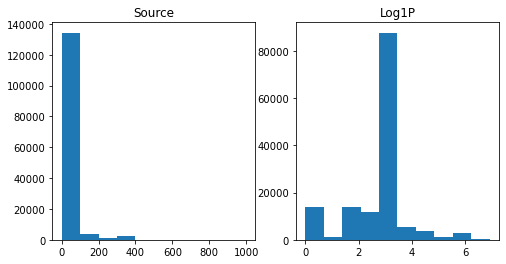

Log1P results for late_fee: -0.7829471160991703


In [4]:
# Analyzing the data, attempting to find an improvements that can be made on the data

print(train.skew().sort_values(ascending=False))

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(train['late_fee'])
ax2.hist(train['late_fee'].apply(np.log1p))
ax1.set(title='Source'), ax2.set(title='Log1P')
plt.show()

# Log1p provides us with much better skew

print("Log1P results for late_fee:", train['late_fee'].apply(np.log1p).skew())

train['late_fee']= train['late_fee'].apply(np.log1p)

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

X = train[desired_columns] # selecting our columns
y_train = train['compliance'] # target column

# Construction of make_column_transformer with specification of columns to be selected for OHE
columns_tran = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), onehot_columns), 
                                       remainder = 'passthrough')
# For clarification purposes seperated fit and transform, could of used fit_transform function
columns_tran.fit(X)
X_train = columns_tran.transform(X) 

X_train.todense()

matrix([[ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  4.33073334],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  4.33073334],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  2.39789527],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  4.61512052],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  3.93182563],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  0.        ]])

4.785003551355693


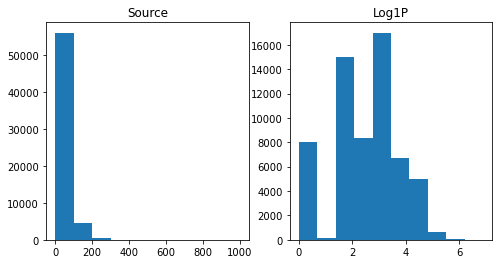

In [6]:
# Data cleaning our test dataset
test.fillna('missing_values', inplace=True)

print(test['late_fee'].skew())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(test['late_fee'])
ax2.hist(test['late_fee'].apply(np.log1p))
ax1.set(title='Source'), ax2.set(title='Log1P')
plt.show()

test['late_fee'] = test['late_fee'].apply(np.log1p)

In [7]:
# Transforming the dataset into OHE matrix
X_test = columns_tran.transform(test)

X_test.todense()

matrix([[ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  3.04452244],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  4.61512052],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  2.39789527],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  2.39789527],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  2.39789527],
        [ 0.        ,  0.        ,  0.        , ..., 20.        ,
         10.        ,  0.        ]])

In [9]:
# Models

from sklearn.model_selection import GridSearchCV


## RandomForest
# from sklearn.ensemble import RandomForestClassifier
# clr = RandomForestClassifier(n_jobs=-1, random_state=0) # Bad result, confusion matrix result: [131760, 37], [9196, 1316]
# Previous calculations have been performed and the best depth resulted in being 20 and n_estimators of 100
# depth, n_estimators = [None, 1, 10, 20], [10, 50, 100, 500]
# param = {'n_estimators': [200], 'max_depth': [20]} # RandomForest
# grid_model = GridSearchCV(clr, param_grid=param, scoring='roc_auc')
# grid_model.fit(X_train, y_train)
# Randomforest has been abandond to check for LinearSVC and see the results of it


### LinearSVC
# from sklearn.svm import LinearSVC
# clr = LinearSVC(C=0.1, max_iter=5000) # Worse result
# param = {'C': [0.1, 0.5, 1, 100], 'max_iter': [3000, 5000, 10000]}
# grid_model = GridSearchCV(clr, param_grid=param, scoring='roc_auc')
# grid_model.fit(X_train, y_train)
# # LinearSVC produced worse results: [131776,     21], [ 10253,    259]

### LogisticRegression
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression()
param = {'C': [0.1, 0.5, 1, 100], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'max_iter': [5000]}
grid_model = GridSearchCV(clr, param_grid=param, scoring='roc_auc')
grid_model.fit(X_train, y_train)


C:\Users\solie\anaconda3\envs\Data-Science\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\solie\anaconda3\envs\Data-Science\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\solie\anaconda3\envs\Data-Science\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\solie\anaconda3\envs\Data-Science\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\solie\anaconda3\envs\Data-Science\lib\site-packages

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.5, 1, 100], 'max_iter': [5000],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [22]:
print('Best parameters: ', grid_model.best_params_)

with open('best_params.txt', 'a') as file:
    print('Best params for {} were: {}'.format(clr, grid_model.best_params_), file=file)

Best parameters:  {'C': 0.1, 'max_iter': 5000, 'solver': 'saga'}


In [2]:
# # Load previously saved model:
import pickle
from pathlib import Path

name = '' #input model name
with open(Path().joinpath('ML_results', name), 'rb') as file:
    grid_model1 = pickle.load(file)

PermissionError: [Errno 13] Permission denied: 'ML_results'

In [34]:
from sklearn.metrics import confusion_matrix

conf_mat = grid_model.predict(X_train)

confusion = confusion_matrix(y_train, conf_mat)

with open('best_params.txt', 'w') as file:
    conf_matrix = 'Confusion matrix: {}'.format(str(confusion).replace('\n', ' '))
    print(conf_matrix, file=file)
    if confusion[0, 0] < confusion[0, 1] or confusion[1, 0] > confusion[1, 1]:
        print('Unsatisfactory', file=file)
    print('\n', file=file)
    
confusion

array([[131607,    190],
       [  9000,   1512]], dtype=int64)

In [43]:
# Saving the result
import pickle 

name = str(clr).replace('()', '')


with open(Path().joinpath('ML_results', name), 'wb') as file:
    pickle.dump(grid_model, file)

In [21]:
y_scores = grid_model.best_estimator_.predict_proba(X_test)
result = pd.DataFrame(y_scores[:, 1], index = result_index, columns = [f'{name} probablity'])

result

,LogisticRegression probablity
ticket_id,
284932,0.028835
285362,0.024037
285361,0.050641
285338,0.041028
285346,0.064329
...,...
376496,0.017889
376497,0.017889
376499,0.046444
